In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils

# Questao 1

Escolha uma das metodologias que voce implementou na segunda lista para gerar correspondencias entre um par de imagens. Aplique-a em 5 pares de imagens (com sobreposicao) para calcular suas homografias, e aplique-as para gerar panoramas entre os pares de imagens (um panorama por par). Obs.: nessa questao, nao e permitido usar a API de alto nıvel Stitcher. Dica: use a funcao warpPerspective da OpenCV.

Step #1: Detect keypoints (DoG, Harris, etc.) and extract local invariant descriptors (SIFT, SURF, etc.) from the two input images.

Step #2: Match the descriptors between the two images.

Step #3: Use the RANSAC algorithm to estimate a homography matrix using our matched feature vectors.

Step #4: Apply a warping transformation using the homography matrix obtained from Step #3.


In [4]:
class Stitcher:
	def __init__(self):
		# determine if we are using OpenCV v3.X
		self.isv3 = imutils.is_cv3(or_better=True)
  
	def stitch(self, images, ratio=0.75, reprojThresh=4.0,
		showMatches=False):
		# unpack the images, then detect keypoints and extract
		# local invariant descriptors from them
		(imageB, imageA) = images
		(kpsA, featuresA) = self.detectAndDescribe(imageA)
		(kpsB, featuresB) = self.detectAndDescribe(imageB)
		# match features between the two images
		M = self.matchKeypoints(kpsA, kpsB,
			featuresA, featuresB, ratio, reprojThresh)
		# if the match is None, then there aren't enough matched
		# keypoints to create a panorama
		if M is None:
			return None

    	# otherwise, apply a perspective warp to stitch the images
		# together
		(matches, H, status) = M
		result = cv2.warpPerspective(imageA, H,
			(imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
		result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
		# check to see if the keypoint matches should be visualized
		if showMatches:
			vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches,
				status)
			# return a tuple of the stitched image and the
			# visualization
			return (result, vis)
		# return the stitched image
		return result

	def detectAndDescribe(self, image):
		# convert the image to grayscale
		gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		# check to see if we are using OpenCV 3.X
		if self.isv3:
			# detect and extract features from the image
			descriptor = cv2.SIFT_create()
			(kps, features) = descriptor.detectAndCompute(image, None)
		# otherwise, we are using OpenCV 2.4.X
		else:
			# detect keypoints in the image
			detector = cv2.FeatureDetector_create("SIFT")
			kps = detector.detect(gray)
			# extract features from the image
			extractor = cv2.DescriptorExtractor_create("SIFT")
			(kps, features) = extractor.compute(gray, kps)
		# convert the keypoints from KeyPoint objects to NumPy
		# arrays
		kps = np.float32([kp.pt for kp in kps])
		# return a tuple of keypoints and features
		return (kps, features)

	def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB,
		ratio, reprojThresh):
		# compute the raw matches and initialize the list of actual
		# matches
		matcher = cv2.DescriptorMatcher_create("BruteForce")
		rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
		matches = []
		# loop over the raw matches
		for m in rawMatches:
			# ensure the distance is within a certain ratio of each
			# other (i.e. Lowe's ratio test)
			if len(m) == 2 and m[0].distance < m[1].distance * ratio:
				matches.append((m[0].trainIdx, m[0].queryIdx))
    
    	# computing a homography requires at least 4 matches
		if len(matches) > 4:
			# construct the two sets of points
			ptsA = np.float32([kpsA[i] for (_, i) in matches])
			ptsB = np.float32([kpsB[i] for (i, _) in matches])
			# compute the homography between the two sets of points
			(H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
				reprojThresh)
			# return the matches along with the homograpy matrix
			# and status of each matched point
			return (matches, H, status)
		# otherwise, no homograpy could be computed
		return None

	def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
		# initialize the output visualization image
		(hA, wA) = imageA.shape[:2]
		(hB, wB) = imageB.shape[:2]
		vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
		vis[0:hA, 0:wA] = imageA
		vis[0:hB, wA:] = imageB
		# loop over the matches
		for ((trainIdx, queryIdx), s) in zip(matches, status):
			# only process the match if the keypoint was successfully
			# matched
			if s == 1:
				# draw the match
				ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
				ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
				cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
		# return the visualization
		return vis

Panorama 0


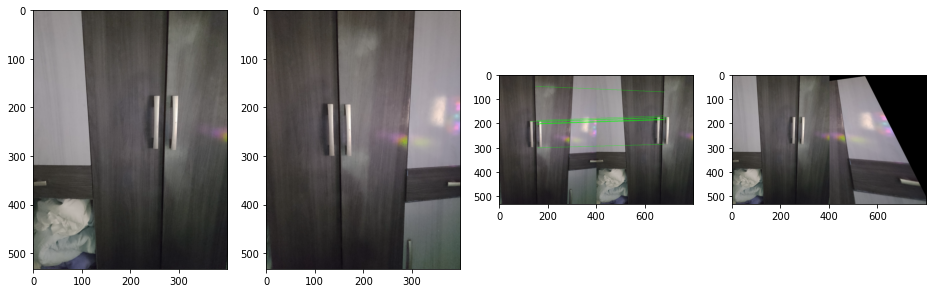

Panorama 1


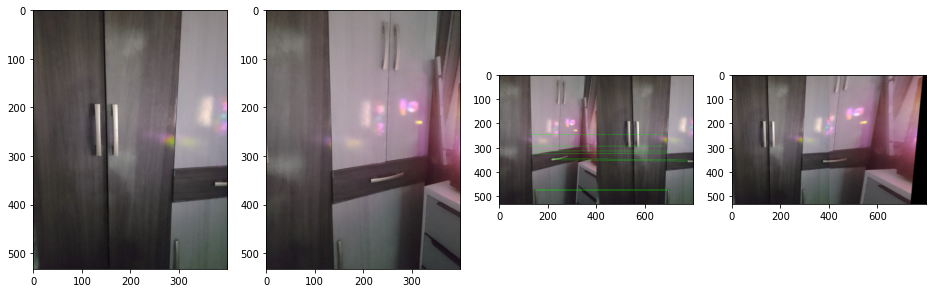

Panorama 2


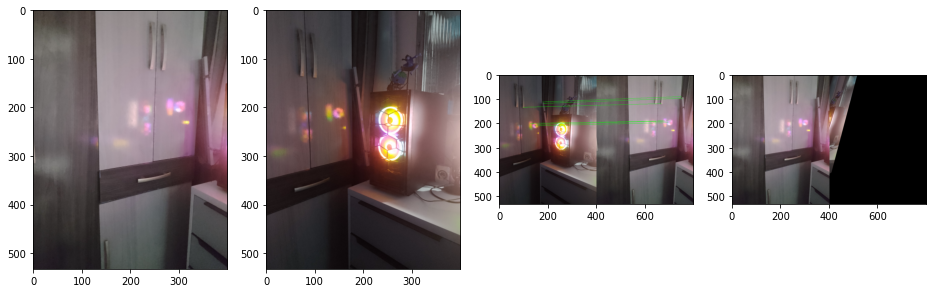

Panorama 3


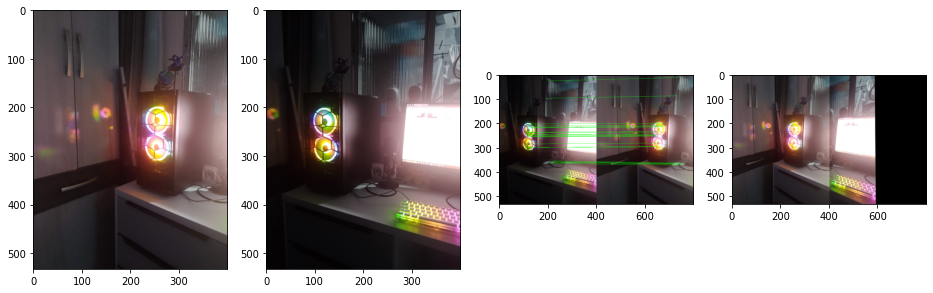

Panorama 4


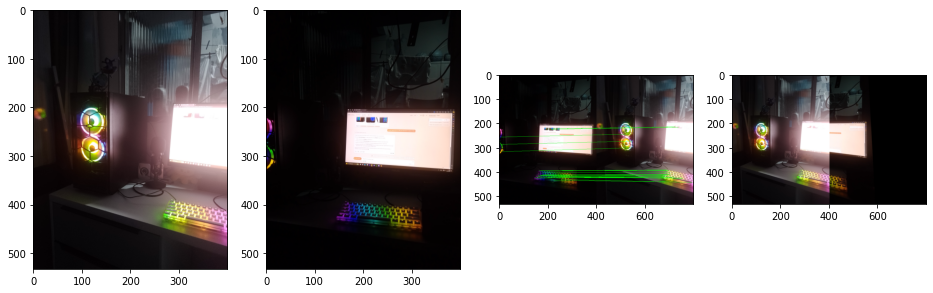

In [5]:
for i in range(0, 5):
    print(f'Panorama {i}')
    
    imageA = cv2.imread(f'./panorama/{i}.jpg')
    imageB = cv2.imread(f'./panorama/{i+1}.jpg')

    imageA = imutils.resize(imageA, width=400)
    imageB = imutils.resize(imageB, width=400)
    # stitch the images together to create a panorama
    stitcher = Stitcher()
    (result, vis) = stitcher.stitch([imageA, imageB], showMatches=True)
    # show the images

    plt.figure(figsize=(16, 16))

    plt.subplot(141), plt.imshow(imageA)
    plt.subplot(142), plt.imshow(imageB)
    plt.subplot(143), plt.imshow(vis)
    plt.subplot(144), plt.imshow(result)
    plt.show()

# Questao 2

Repita a questao anterior com 5 trios de imagens (com sobreposicao 2 a 2), alinhando as imagens no plano da primeira imagem. Repita o mesmo alinhando no plano da segunda imagem, e da terceira imagem. Note que aqui sera necessario compor as transformacoes de homografia em alguns casos, ou calcular inversas.

## Tentativa 1

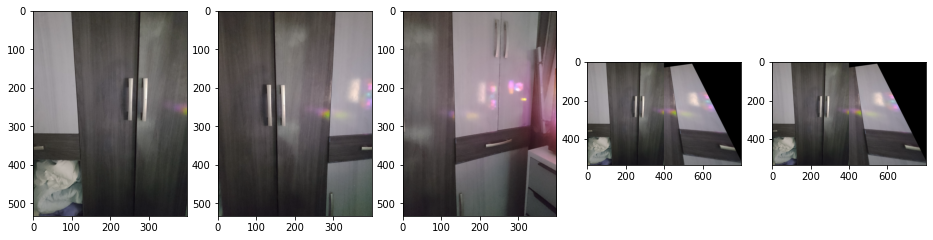

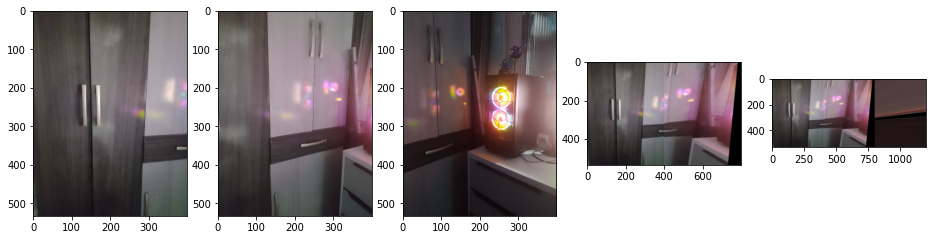

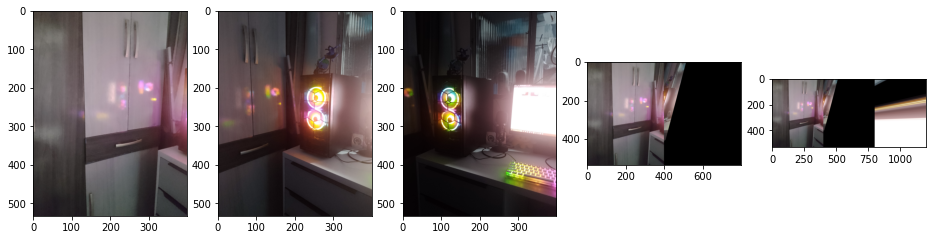

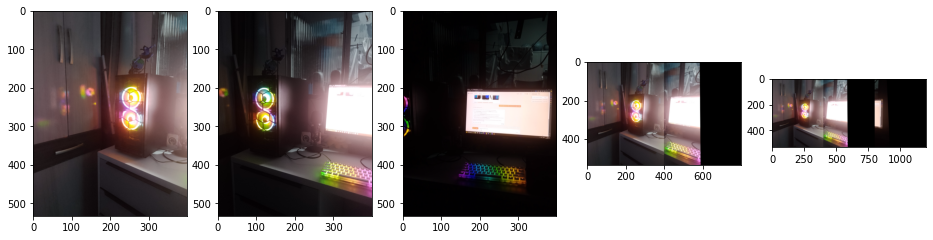

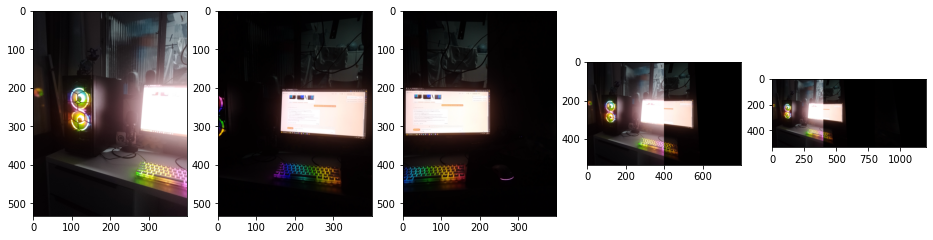

In [6]:
for i in range(0, 5):
    img1 = cv2.imread(f'./panorama/{i}.jpg')
    img2 = cv2.imread(f'./panorama/{i+1}.jpg')
    img3 = cv2.imread(f'./panorama/{i+2}.jpg')

    # Criar panoramas alinhando no plano da primeira, segunda e terceira imagem
    img1 = imutils.resize(img1, width=400)
    img2 = imutils.resize(img2, width=400)
    img3 = imutils.resize(img3, width=400)
    
    stitcher = Stitcher()
    panorama1 = stitcher.stitch([img1, img2])
    panorama2 = stitcher.stitch([panorama1, img3])

    if panorama2 is None:
        panorama2 = panorama1
        

    plt.figure(figsize=(16,16))
    plt.subplot(151), plt.imshow(img1)
    plt.subplot(152), plt.imshow(img2)
    plt.subplot(153), plt.imshow(img3)
    plt.subplot(154), plt.imshow(panorama1)
    plt.subplot(155), plt.imshow(panorama2)
    plt.show()

## Tentativa 2

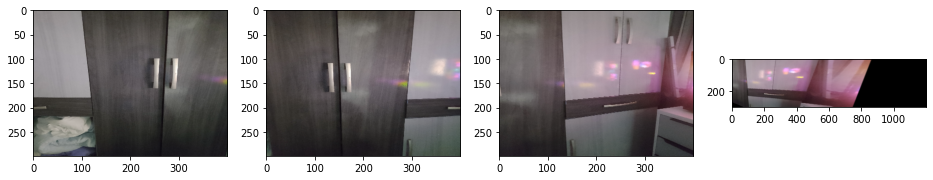

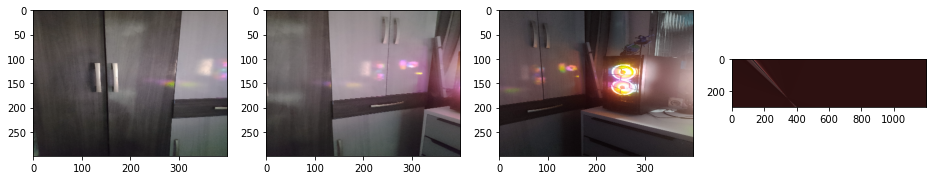

Não há correspondências suficientes para calcular a homografia.


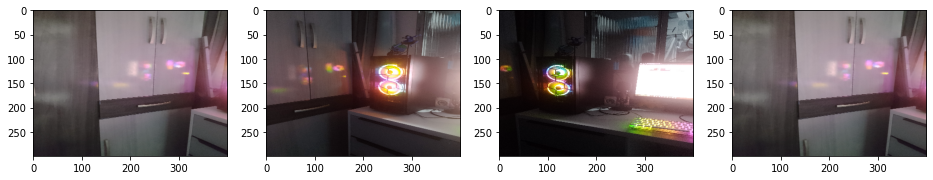

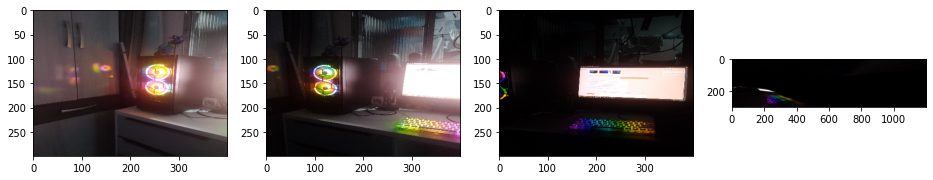

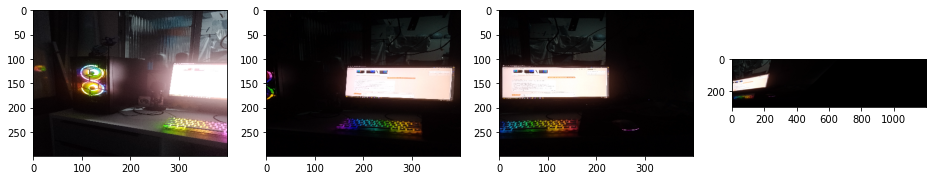

In [49]:
def align_images(image1, image2):
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
            
    if len(good_matches) < 4:
        print("Não há correspondências suficientes para calcular a homografia.")
        return None, None

    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    if H is None:
        return None, None
    aligned_image = cv2.warpPerspective(image2, H, (image1.shape[1] + image2.shape[1], image1.shape[0]))

    return aligned_image, H

def create_panorama(images, reference_idx=0):
    idx_prox = 0 if reference_idx == 1 else 1
    idx_longe = 0 if reference_idx == 2 else 2
    
    # Alinhar a imagem a mais proxima
    aligned_image1, H1 = align_images(images[reference_idx], images[idx_prox])
    
    if aligned_image1 is None:
        return None

    # Alinhar com a imagem mais longe
    aligned_image2, H2 = align_images(aligned_image1, images[idx_longe])
    
    if aligned_image2 is None:
        return None

    # Combinar as imagens alinhadas para criar o panorama final
    panorama = cv2.warpPerspective(images[reference_idx], H1, (aligned_image1.shape[1] + images[idx_longe].shape[1], images[reference_idx].shape[0]))
    panorama[0:aligned_image2.shape[0], 0:aligned_image2.shape[1]] = aligned_image2

    return panorama

for i in range(0, 5):
    image1 = cv2.imread(f'./panorama/{i}.jpg')
    image2 = cv2.imread(f'./panorama/{i+1}.jpg')
    image3 = cv2.imread(f'./panorama/{i+2}.jpg')

    image1 = cv2.resize(image1, (400, 300))
    image2 = cv2.resize(image2, (400, 300))
    image3 = cv2.resize(image3, (400, 300))

    panorama = create_panorama([image1, image2, image3], 0)
    
    if panorama is None:
        panorama = image1

    plt.figure(figsize=(16,16))
    plt.subplot(141), plt.imshow(image1)
    plt.subplot(142), plt.imshow(image2)
    plt.subplot(143), plt.imshow(image3)
    plt.subplot(144), plt.imshow(panorama)
    plt.show()

# Questao 3

Use homografias para trocar as bandeiras dos paıses na imagem abaixo (e em anexo no classroom) por outras bandeiras. Preencha tambem a placa de publicidade onde ha o nome ”London 2012” por outra imagem de publicidade de sua escolha.

Dica: leia este tutorial, https://medium.com/acmvit/how-to-project-an-image-in-perspective-view-of-a-background-image-opencv-python-d101bdf966bc

# Questao 4

Leia o seguinte tutorial de calibracao de camera: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html Voce vai precisar de um tabuleiro de xadrez (pode imprimir numa folha A4, e colar num papelao ou emplastificar para a geometria ficar fixa). Meca as dimensoes do seu tabuleiro para calibrar a camera, considerando que o tabuleiro sempre esta no plano z = 0, e que o canto inferior esquerdo do tabuleiro e a origem (0, 0, 0). Apos calibrar a camera, vamos incluir um objeto virtual na imagem. Considere a seguinte equacao parametrica do cırculo centrado no ponto (1.5W, 1.5H, 0), com raio r = 0.5W e contido no plano z = 0, onde H e W sao a as medidas da altura e largura do tabuleiro:

p(θ) = (r cos θ + 1.5W, r sen θ + 1.5H, 0).

Se assegure de que o cırculo apareca na imagem, de acordo com a posicao do xadrez na imagem. Para desenhar o cırculo, varie o valor do angulo θ entre 0 e 2π para amostrar alguns pontos, e projete-os na imagem. Repita isso 3 vezes, variando o angulo entre o vetor normal do tabuleiro e o eixo principal da camera.